In [40]:
#%%
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [41]:
batch_size = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True,
                   transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size, shuffle=True
)


In [42]:
class Net(nn.Module):
    #%%补全以下代码
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)    # 输入1通道，输出6通道，5x5卷积核
        self.conv2 = nn.Conv2d(6, 16, 5)   # 输入6通道，输出16通道，5x5卷积核
        # 修正：fc1的输入维度为4*4*16=256（原错误是5*5*16=400）
        self.fc1 = nn.Linear(4*4*16, 120)    
        self.fc2 = nn.Linear(120, 84)  #全连接层,输入120,输出84      
        self.clf = nn.Linear(84, 10)   #分类层,输入84,输出10

    def forward(self, x):
        #conv1
        #激活函数sigmoid()
        #平均池化层,kernel=2x2,步长2
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  # 28→24→12

        #conv2
        #激活函数sigmoid()
        #平均池化层,2x2,步长2
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = F.avg_pool2d(x, kernel_size=2, stride=2)  # 12→8→4

         #展平,从第1维开始展平
        x = x.view(x.size(0), -1)
        
        #全连接层1
        #激活函数sigmoid()
        #全连接层2
        #激活函数sigmoid()
        #分类层
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.clf(x)
        return x

In [43]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (clf): Linear(in_features=84, out_features=10, bias=True)
)

In [44]:
epochs = 30
for epoch in range(epochs):
    accs, losses = [], []
    for batch_idx, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()

    correct = 0
    with torch.no_grad():
        testloss = 0
        for batch_idx, (x, y) in enumerate(testloader):
            x, y = x.to(device), y.to(device)
            out = model(x)
            testloss += F.cross_entropy(out, y).item()
            pred = out.max(dim=1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
        acc = correct / len(testloader.dataset)
        testloss = testloss / (batch_idx + 1)
        accs.append(acc)
        losses.append(testloss)
        print('epoch:{}, loss:{:.4f}, acc:{:.4f}'.format(epoch, testloss, acc))

    

epoch:0, loss:2.3014, acc:0.1135
epoch:1, loss:2.3009, acc:0.1135
epoch:2, loss:2.0295, acc:0.2736
epoch:3, loss:0.3533, acc:0.8904
epoch:4, loss:0.1507, acc:0.9534
epoch:5, loss:0.1128, acc:0.9651
epoch:6, loss:0.0836, acc:0.9745
epoch:7, loss:0.0709, acc:0.9774
epoch:8, loss:0.0593, acc:0.9818
epoch:9, loss:0.0612, acc:0.9819
epoch:10, loss:0.0580, acc:0.9819
epoch:11, loss:0.0543, acc:0.9830
epoch:12, loss:0.0494, acc:0.9844
epoch:13, loss:0.0466, acc:0.9854
epoch:14, loss:0.0492, acc:0.9850
epoch:15, loss:0.0494, acc:0.9848
epoch:16, loss:0.0542, acc:0.9837
epoch:17, loss:0.0466, acc:0.9855
epoch:18, loss:0.0434, acc:0.9867
epoch:19, loss:0.0447, acc:0.9860
epoch:20, loss:0.0447, acc:0.9867
epoch:21, loss:0.0407, acc:0.9882
epoch:22, loss:0.0463, acc:0.9853
epoch:23, loss:0.0499, acc:0.9860
epoch:24, loss:0.0445, acc:0.9876
epoch:25, loss:0.0453, acc:0.9854
epoch:26, loss:0.0446, acc:0.9871
epoch:27, loss:0.0417, acc:0.9876
epoch:28, loss:0.0493, acc:0.9860
epoch:29, loss:0.0495, a

In [45]:
#%%
feature1 = F.sigmoid(model.conv1(x))
# feature1 = F.avg_pool2d(feature1, kernel_size=2, stride=2)
feature2 = F.sigmoid(model.conv2(feature1))
# feature2 = F.avg_pool2d(feature2, kernel_size=2, stride=2)


In [46]:
n = 5
img = x.detach().cpu().numpy()[:n]
feature_map1 = feature1.detach().cpu().numpy()[:n]
feature_map2 = feature2.detach().cpu().numpy()[:n]

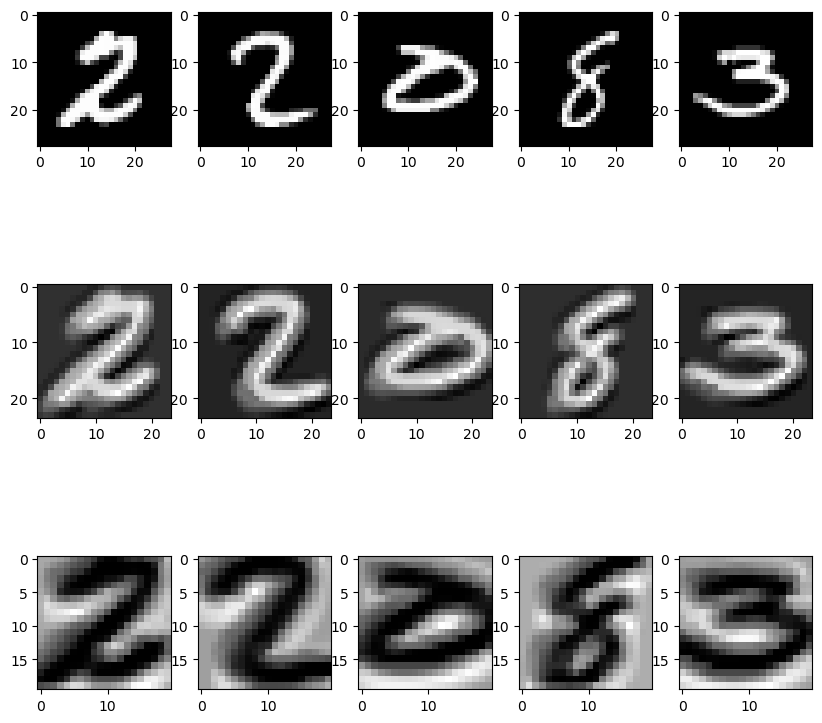

In [47]:
fig, ax = plt.subplots(3, n, figsize=(10, 10))
for i in range(n):
    # ax[0,i].axis('off')
    ax[0, i].imshow(img[i].sum(0), cmap='gray')
    # ax[1,i].axis('off')
    ax[1, i].imshow(feature_map1[i].sum(0), cmap='gray')
    # ax[2,i].axis('off')
    ax[2, i].imshow(feature_map2[i].sum(0), cmap='gray')

plt.show()